In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2022-03-13 16:15:40--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  10.8MB/s    in 26s     

2022-03-13 16:16:08 (10.0 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
import zipfile

with zipfile.ZipFile('/content/GTSRB_Final_Training_Images.zip','r') as target_file:

    target_file.extractall()

    print('data is extracted into GTSRB dir !')

data is extracted into GTSRB dir !


In [ ]:
import os
from glob import glob

label_name_list = os.listdir('/content/GTSRB/Final_Training/Images/')

print('total label nums = ', len(label_name_list))
print('='*50)
print(label_name_list)

total label nums =  43
['00008', '00042', '00039', '00034', '00009', '00000', '00019', '00040', '00024', '00011', '00025', '00041', '00016', '00032', '00004', '00001', '00027', '00006', '00022', '00018', '00026', '00038', '00036', '00031', '00037', '00015', '00029', '00007', '00002', '00014', '00012', '00030', '00003', '00017', '00020', '00013', '00033', '00035', '00023', '00021', '00028', '00010', '00005']


In [ ]:
import cv2

image_list = []
label_list = []

image_base_dir = '/content/GTSRB/Final_Training/Images/'

image_label_list = os.listdir(image_base_dir)

print('total label nums = ', len(image_label_list))


for label_name in image_label_list:

    file_path = image_base_dir + label_name

    img_file_list = glob(file_path+'/*.ppm')

    for img_file in img_file_list:

        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(32,32))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

        if src_img is None:
            continue
        image_list.append(src_img)
        label_list.append(float(label_name))

total label nums =  43


In [ ]:
import numpy as np

x_data = np.array(image_list).astype('float32')
y_data = np.array(label_list).astype('float32')

print('x_data.shape = {}, y_data.shape = {}'.format(x_data.shape, y_data.shape))

x_data.shape = (39209, 32, 32, 3), y_data.shape = (39209,)


In [ ]:
s = np.arange(len(y_data))

np.random.shuffle(s)

x_data = x_data[s]
y_data = y_data[s]

In [ ]:
ratio = 0.2

split_num = int(len(y_data)*0.2)

print('split_num => ',split_num)

x_test = x_data[:split_num]
y_test = y_data[:split_num]

x_train = x_data[split_num:]
y_train = y_data[split_num:]

print('x_train.shape %s, y_train.shape %s' %(x_train.shape, y_train.shape))
print('x_test.shape %s, y_test.shape %s' %(x_test.shape, y_test.shape))

split_num =>  7841
x_train.shape (31368, 32, 32, 3), y_train.shape (31368,)
x_test.shape (7841, 32, 32, 3), y_test.shape (7841,)


In [ ]:
# 정규화
x_train = x_train / 255.0
x_test = x_test / 255.0

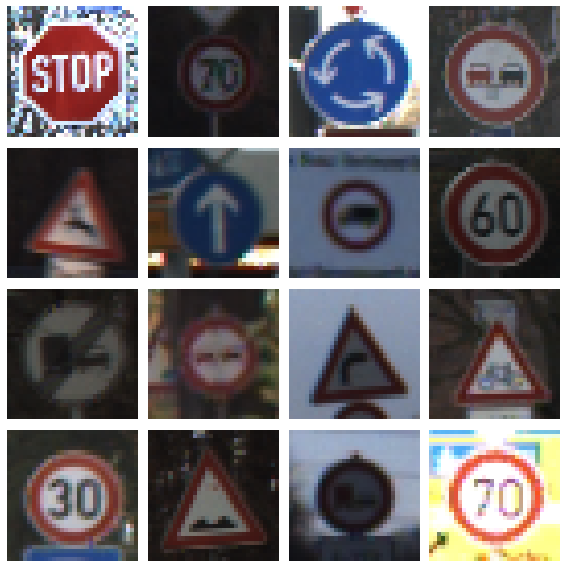

In [ ]:
import matplotlib.pyplot as plt

random_index = np.random.randint(0,len(x_train),16)

plt.figure(figsize=(8,8))
for pos in range(len(random_index)):
    plt.subplot(4,4,pos+1)
    plt.axis('off')
    train_img_index = random_index[pos]
    plt.imshow(x_train[train_img_index])

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [ ]:
n_classes = len(os.listdir('/content/GTSRB/Final_Training/Images/'))

model = Sequential()
model.add(Conv2D(input_shape=(32,32,3),kernel_size=3, filters=32, activation='relu',padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
model.add(Dropout(0.25))

model.add(Conv2D(kernel_size=3, filters=32, activation='relu',padding='SAME'))
model.add(MaxPool2D(pool_size=(2,2),padding='SAME'))
model.add(Dropout(0.25))

model.add(Conv2D(kernel_size=3, filters=32, activation='relu',padding='SAME'))

model.add(Flatten())
model.add(Dense(n_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)          0

In [ ]:
model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_dir = '/content/GTSRB/Models'
save_file_name = save_dir+'/GTSRB_Native_Colab.h5'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print('Model save dir created !')

checkpoint = ModelCheckpoint(save_file_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=5)

hist = model.fit(x_train,y_train, 
                 epochs=30, batch_size=32, 
                 validation_data=(x_test,y_test),
                 callbacks=[checkpoint,earlystopping])

Model save dir created !
Epoch 1/30
981/981 [==============================] - ETA: 0s - loss: 1.3980 - accuracy: 0.5974
Epoch 1: val_loss improved from inf to 0.35737, saving model to /content/GTSRB/Models/GTSRB_Native_Colab.h5
981/981 [==============================] - 18s 8ms/step - loss: 1.3980 - accuracy: 0.5974 - val_loss: 0.3574 - val_accuracy: 0.9040
Epoch 2/30
980/981 [============================>.] - ETA: 0s - loss: 0.3229 - accuracy: 0.9022
Epoch 2: val_loss improved from 0.35737 to 0.16462, saving model to /content/GTSRB/Models/GTSRB_Native_Colab.h5
981/981 [==============================] - 8s 8ms/step - loss: 0.3228 - accuracy: 0.9022 - val_loss: 0.1646 - val_accuracy: 0.9565
Epoch 3/30
975/981 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9466
Epoch 3: val_loss improved from 0.16462 to 0.10583, saving model to /content/GTSRB/Models/GTSRB_Native_Colab.h5
981/981 [==============================] - 7s 8ms/step - loss: 0.1769 - accuracy: 0.9466 - v

In [ ]:
model.evaluate(x_test,y_test)

246/246 [==============================] - 1s 4ms/step - loss: 0.0407 - accuracy: 0.9925


[0.04066978022456169, 0.9924754500389099]

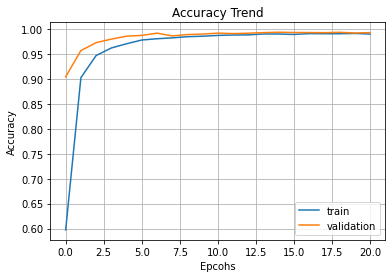

In [ ]:
plt.title('Accuracy Trend')
plt.grid()
plt.xlabel('Epcohs')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='validation')
plt.legend(loc='best')
plt.show()

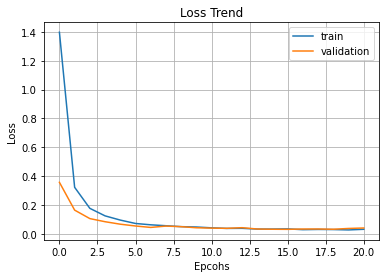

In [ ]:
plt.title('Loss Trend')
plt.grid()
plt.xlabel('Epcohs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='validation')
plt.legend(loc='best')
plt.show()